In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

import os
import pickle

import time

In [2]:
import PyNAFF as pnf

from tune_diagram import ResonanceLines

In [3]:
from scipy.constants import e, m_p, c, epsilon_0
from scipy.constants import physical_constants

In [4]:
from cpymad.madx import Madx

import sixtracklib as pyst
import pysixtrack

In [5]:
import pysixtrack.be_beamfields.tools as bt

In [6]:
import sys
sys.path.append('/home/oeftiger/gsi/git/python3/PyHEADTAIL/'), 
sys.path.append('/home/oeftiger/gsi/git/')

In [7]:
from pycuda.autoinit import context
from pycuda import gpuarray as gp

from pycuda.driver import memcpy_dtod_async

In [8]:
from PyHEADTAIL.general.element import Element
from PyHEADTAIL.general import pmath as pm
from PyHEADTAIL.particles import generators

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.spacecharge.pypic_factory import create_3dmesh_from_beam, create_mesh
from PyHEADTAIL.spacecharge.pypic_spacecharge import (
    SpaceChargePIC, SpaceChargePIC_Adaptive25D)

from PyHEADTAIL.monitors.monitors import BunchMonitor, ParticleMonitor

from PyHEADTAIL.general.contextmanager import GPU

from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5




/home/oeftiger/anaconda3/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


PyPIC v2.4.1.2
Info: cusolver_Rf not found. GPU finite difference solver not available.


In [9]:
from PyPIC.GPU.poisson_solver.FFT_solver import (
    GPUFFTPoissonSolver_2_5D, GPUFFTPoissonSolver)
from PyPIC.GPU.pypic import PyPIC_GPU

# not necessary but nice: memory pool sharing between PyHEADTAIL and PyPIC
try:
    from PyHEADTAIL.gpu.gpu_utils import memory_pool
except:
    memory_pool = None

# VERSIONING

## SixTrackLib:

In [10]:
f = os.path.dirname(pyst.__file__)
f

'/home/oeftiger/gsi/git/sixtracklib_aoeftiger/python/sixtracklib'

In [11]:
!cd $f && git log | head -4

commit f42c420da20602c9c4c08172338ed3019bb20d25
Merge: deff9373 20f49532
Author: Adrian Oeftiger <a.oeftiger@gsi.de>
Date:   Wed Jan 8 14:52:08 2020 +0100


## PySixTrack:

In [12]:
f = os.path.dirname(pysixtrack.__file__)
f

'/home/oeftiger/gsi/git/pysixtrack/pysixtrack'

In [13]:
!cd $f && git log | head -4

commit a1c73d9578a20e404dff54e1330aebe77eb763d5
Merge: 1d8f5db 4ce2927
Author: Riccardo De Maria <riccardodemaria@gmail.com>
Date:   Wed Jan 8 17:48:29 2020 +0100


# Parameters

In [14]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
# nmass = 0.931494061 # MAD-X value

In [15]:
tune_range_qx = np.arange(18.55, 18.95 + 0.01, 0.01)
tune_range_qy = tune_range_qx

In [16]:
n_macroparticles = int(1e6)
n_turns = 128 #20000 #2**16

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

intensity = 0.625e11

# fixed grid for space charge
n_slices_sc = 64
n_mesh_nodes = 256
n_mesh_sigma = 24
n_scnodes = 501

Qx = 18.95
Qy = 18.93

###

mass_eV = A * nmass * 1e9
mass = mass_eV * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [17]:
epsx_rms_fin = 35e-6 / 4 # geometrical emittances
epsy_rms_fin = 15e-6 / 4

limit_n_rms_x = 2
limit_n_rms_y = 2
limit_n_rms_z = 2

sig_z_orig = 58 / 4. * 0.3/0.33 # in m
sig_dp_orig = 0.5e-3 * 0.3/0.33

V_rf = 58.2e3

###

epsx_gauss = epsx_rms_fin * 1.43 #1.48 #1.778 #RMS adjustment not needed if limit_n_rms are >>2!
epsy_gauss = epsy_rms_fin * 1.41 #1.43 #1.82 #RMS adjustment not needed if limit_n_rms are >>2!

epsn_x = epsx_gauss * beta * gamma
epsn_y = epsy_gauss * beta * gamma

# sig_z = 1.22 * sig_z_orig
# sig_dp = 1.19 * sig_dp_orig

sig_z = sig_z_orig
sig_dp = sig_dp_orig

beta_z = sig_z / sig_dp

# 1. with errors, no aperture $Q_x=.95, Q_y=.93$

In [19]:
!mkdir error_tables/

In [20]:
# e_seed = 1

qx = Qx
qy = Qy

install_apertures = False
apply_errors = True
e_seed = 1

qqx, qqy = int(np.round((qx%1) * 100)), int(np.round((qy%1) * 100))

filename_error_table = "./error_tables/errors_{qqx}_{qqy}_{eseed:d}".format(
            qqx=qqx, qqy=qqy, eseed=e_seed)

madx = Madx()
madx.options.echo = False
madx.options.warn = False

madx.call('./SIS100_RF_220618_9slices.thin.seq')

madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot) # /Q for RF to have proton beam!

madx.call('OpticsYEH_BeamParameters.str')
madx.call('Coll+Errors+BeamDistr.madx')

madx.use(sequence='sis100ring')

### --> first match, then add errors, then TWISS!

madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=qx, qy=qy)
)

if apply_errors:
    madx.command.eoption(add=True, seed=e_seed)
    madx.command.exec('EA_EFCOMP_MH()')
    for s in range(1, 10):
        assert madx.command.exec(f'EA_rEFCOMP_QD({s},1)')

twiss = madx.twiss();

if apply_errors:
    madx.command.select(flag='error', pattern='QD11..', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='QD12..', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='mh1', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='mh2', class_='MULTIPOLE')
    madx.command.esave(file=filename_error_table)

if apply_errors:
    madx.command.readtable(file=filename_error_table, table="errors")
    errors = madx.table.errors

sis100 = madx.sequence.sis100ring


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.02.12 18:14:03      +
  ++++++++++++++++++++++++++++++++++++++++++++
START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.86458872e-11





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.82655e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.82042e-01 -2.80616e-01 -1.00000e+20  1.

In [21]:
pysixtrack_elements_temp = pysixtrack.Line.from_madx_sequence(sis100)

In [22]:
l_target = twiss.summary.length / (n_scnodes)
l_fuzz = l_target / 2.

sc_locations, sc_lengths = bt.determine_sc_locations(
    pysixtrack_elements_temp, n_scnodes, l_fuzz
)

In [23]:
sc_names = ["sc%d" % number for number in range(len(sc_locations))]

In [24]:
bt.install_sc_placeholders(madx, 'SIS100RING', sc_names, sc_locations, mode='Bunched')

In [25]:
from pysixtrack.elements import DriftExact
class myDriftExact(DriftExact):
    def __new__(cls, *args, **kwargs):
        return DriftExact.__new__(DriftExact, length=0.)

In [26]:
pysixtrack.elements.SpaceChargeBunched = myDriftExact

In [27]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    sis100, exact_drift=True, install_apertures=install_apertures
)

# pysixtrack_elements.remove_zero_length_drifts(inplace=True);
# pysixtrack_elements.merge_consecutive_drifts(inplace=True);

In [28]:
mad_sc_names, sc_twdata = bt.get_spacecharge_names_twdata(
    madx, "SIS100RING", mode='Bunched'
)

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       1083.599999                 -0     0.003995303318        15.82067912 

                q1                dq1            betxmax              dxmax 
             18.95       -40.26536356        20.63113216         3.04497454 

             dxrms             xcomax             xcorms                 q2 
       1.349029736                  0                  0        18.92999954 

               dq2            betymax              dymax              dyrms 
      -40.80188065        23.64657858                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [27]:
# sc_elements, sc_names = pysixtrack_elements.get_elements_of_type(
#     pysixtrack.elements.SpaceChargeBunched
# )

In [28]:
# bt.check_spacecharge_consistency(
#     sc_elements, sc_names, sc_lengths, mad_sc_names
# )

In [29]:
# # Setup spacecharge in the line
# bt.setup_spacecharge_bunched_in_line(
#     sc_elements,
#     sc_lengths,
#     sc_twdata,
#     beta * gamma,
#     intensity,
#     sig_z_orig,
#     sig_dp_orig,
#     epsx_rms_fin * beta * gamma,
#     epsy_rms_fin * beta * gamma,
# )

In [30]:
# sc_sig_x = [el.sigma_x for el in sc_elements]
# sc_sig_y = [el.sigma_y for el in sc_elements]

Remove `SpaceChargeBunched` from PySixTrack `Line`:

In [29]:
ids_sc = [i for i, el in enumerate(pysixtrack_elements.elements) 
          if hasattr(el, 'length') and el.length is 0]

# for i in ids_sc[::-1]:
#     pysixtrack_elements.element_names.pop(i)
#     pysixtrack_elements.elements.pop(i)

# ids_sc = np.asarray(ids_sc) - np.arange(len(ids_sc)) # always starts with 0

In [30]:
assert ids_sc[-1] != len(pysixtrack_elements.elements), \
    'The last element is a SpaceChargeBunched (as well as the first!)'
# ids_sc = ids_sc[:-1] # remove the redundant SC node at the end of the lattice

# Particle generation

In [57]:
cavities = [f for f in pysixtrack_elements.elements if 'avity' in str(f)]
for f in cavities:
    f.voltage = V_rf / float(len(cavities))

In [58]:
# voltages of all SIS100 cavities:
sum([f.voltage for f in pysixtrack_elements.elements if 'avity' in str(f)])

58199.99999999998

In [59]:
# madx.input('cavity_voltage = 58.2/1000/number_cavities;')

In [60]:
# particle initialisation from pyheadtail

x_co = twiss['x'][0]
y_co = twiss['y'][0]
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta
Dp_x_0 = twiss['dpx'][0] * beta
Dp_y_0 = twiss['dpy'][0] * beta

np.random.seed(0)

pyht_beam = generators.generate_Gaussian6DTwiss(
    n_macroparticles, intensity, charge, mass, twiss.summary.length, gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    1, epsn_x, epsn_y, 1,
    dispersion_x=None, #D_x_0 if D_x_0 else None,
    dispersion_y=None, #D_y_0 if D_y_0 else None,
    limit_n_rms_x=limit_n_rms_x**2, limit_n_rms_y=limit_n_rms_y**2, 
    limit_n_rms_z=limit_n_rms_z**2,
)

distribution_z_uncut = generators.gaussian2D(
    sig_z**2)
is_accepted = generators.make_is_accepted_within_n_sigma(
    epsn_rms=sig_z,
    limit_n_rms=limit_n_rms_z,
)
distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

z, dp = distribution_z_cut(n_macroparticles)
pyht_beam.z, pyht_beam.dp = z, dp / beta_z

# PyHT generates around 0, need to offset with closed orbit:
pyht_beam.x += x_co
pyht_beam.y += y_co
# add dispersive contribution to coordinates:
pyht_beam.x += D_x_0 * pyht_beam.dp
pyht_beam.y += D_y_0 * pyht_beam.dp
# also need to add D'_{x,y} to momenta:
pyht_beam.xp += Dp_x_0 * pyht_beam.dp
pyht_beam.yp += Dp_y_0 * pyht_beam.dp

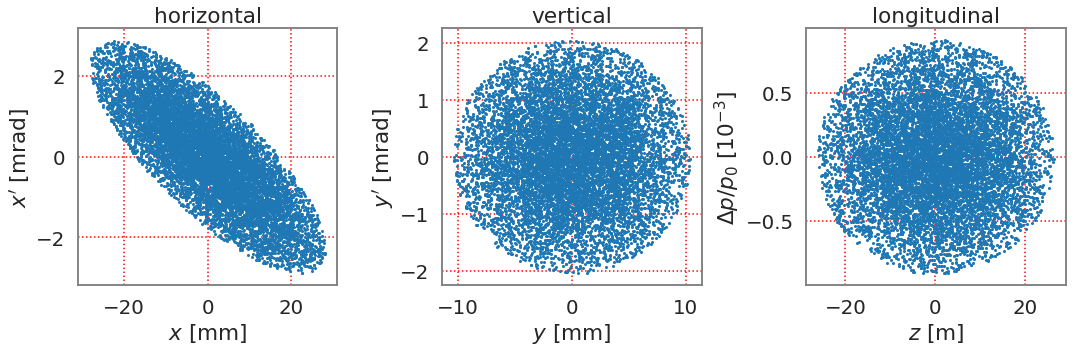

In [61]:
plot_every = 100

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')
plt.scatter(pyht_beam.x[::plot_every] * 1e3, pyht_beam.xp[::plot_every] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")

# plt.axvline(pyht_beam.sigma_x(), color='red')
# plt.axvline(2*pyht_beam.sigma_x(), color='red')
# plt.axvline(3*pyht_beam.sigma_x(), color='red')
# plt.axvline(3.4*pyht_beam.sigma_x(), color='red')

# ep = mpl.patches.Ellipse(
#     (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3.4*2*pyht_beam.sigma_x() * 1e3, 3.4*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='solid')
# plt.gca().add_patch(ep)

plt.sca(ax[1])
plt.title('vertical')
plt.scatter(pyht_beam.y[::plot_every] * 1e3, pyht_beam.yp[::plot_every] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")

plt.sca(ax[2])
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::plot_every], pyht_beam.dp[::plot_every] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0$ [$10^{-3}$]")
plt.tight_layout()

plt.savefig('particle_generation_phasespaces.png', dpi=150, bbox_inches='tight')

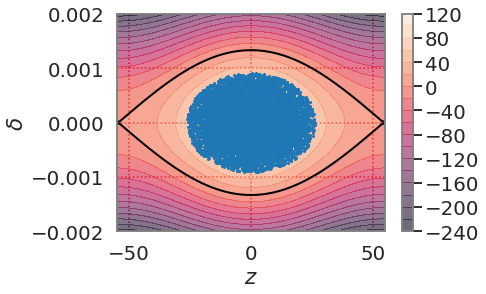

In [62]:
rfb = RFBucket(twiss.summary.length, gamma, mass, charge, [twiss.summary['gammatr']**-2], 
               0, [10], [V_rf], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.002, 0.002, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='black', linewidths=2)
plt.scatter(pyht_beam.z[::plot_every], pyht_beam.dp[::plot_every], s=10, marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [66]:
# add alignment and multipole errors

if apply_errors:
#     raise NotImplementedError(
#         'ids_sc should take into account additional misalignment error elements!')
    sc_elements = [el for el in pysixtrack_elements.elements
                   if hasattr(el, 'length') and el.length is 0]

    pysixtrack_elements.apply_madx_errors(error_table=errors)

    ids_sc_new = [list(map(id, pysixtrack_elements.elements)).index(id(sc_el))
                  for sc_el in sc_elements]
    ids_sc = ids_sc_new

### Load lattice into SixTrackLib

elements = pyst.Elements.from_line(pysixtrack_elements)
# elements.BeamMonitor(num_stores=n_turns);

### Transfer particles into SixTrackLib
particles = pyst.Particles.from_ref(n_macroparticles, p0c=p0c, mass0=mass_eV, q0=Q)

particles.x[:] = pyht_beam.x
particles.px[:] = pyht_beam.xp
particles.y[:] = pyht_beam.y
particles.py[:] = pyht_beam.yp
particles.zeta[:] = pyht_beam.z
particles.delta[:] = pyht_beam.dp

particles.rpp[:] = 1. / (pyht_beam.dp + 1)

restmass = mass * c**2
restmass_sq = restmass**2
E0 = np.sqrt((p0 * c)**2 + restmass_sq)
p = p0 * (1 + pyht_beam.dp)
E = np.sqrt((p * c)**2 + restmass_sq)
particles.psigma[:] = (E - E0) / (beta * p0 * c)

gammai = E / restmass
betai = np.sqrt(1 - 1. / (gammai * gammai))
particles.rvv[:] = betai / beta

### prepare trackjob in SixTrackLib

# trackjob = pyst.TrackJob(elements, particles)
# trackjob = pyst.TrackJob(elements, particles, device=pystl_device)
trackjob = pyst.CudaTrackJob(elements, particles)

print ('\n\n\n' + '+'*26 + '\n*** ready for tracking ***\n' + '+'*26 + '\n')




++++++++++++++++++++++++++
*** ready for tracking ***
++++++++++++++++++++++++++



# Interface to PyHEADTAIL

In [67]:
from pycuda import cumath

def provide_pycuda_array(ptr):
    return gp.GPUArray(n_macroparticles, dtype=np.float64, gpudata=ptr)

class TrackSixTrackLib(Element):
    '''General state.'''
    trackjob = None
    pointers = {}
    context = None
    n_elements = 0

    def __init__(self, trackjob, i_start, i_end, context=context):
        if TrackSixTrackLib.trackjob is None:
            TrackSixTrackLib.trackjob = trackjob

            trackjob.fetch_particle_addresses()
            assert trackjob.last_status_success
            ptr = trackjob.get_particle_addresses() # particleset==0 is default

            TrackSixTrackLib.pointers.update({
                'x': provide_pycuda_array(ptr.contents.x),
                'px': provide_pycuda_array(ptr.contents.px),
                'y': provide_pycuda_array(ptr.contents.y),
                'py': provide_pycuda_array(ptr.contents.py),
                'z': provide_pycuda_array(ptr.contents.zeta),
                'delta': provide_pycuda_array(ptr.contents.delta),
                'rpp': provide_pycuda_array(ptr.contents.rpp),
                'psigma': provide_pycuda_array(ptr.contents.psigma),
                'rvv': provide_pycuda_array(ptr.contents.rvv),
            })
            TrackSixTrackLib.n_elements = len(trackjob.beam_elements_buffer.get_elements())

        self.i_start = i_start
        self.i_end = i_end
        self.is_last_element = (i_end == self.n_elements)

        self.context = context

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        trackjob.track_line(self.i_start, self.i_end, 
                            finish_turn=self.is_last_element)
        # to be replaced by barrier:
        trackjob.collectParticlesAddresses()

        assert trackjob.last_track_status_success
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        self.memcpy(self.pointers['x'], beam.x)
        self.memcpy(self.pointers['px'], beam.xp)
        self.memcpy(self.pointers['y'], beam.y)
        self.memcpy(self.pointers['py'], beam.yp)
        self.memcpy(self.pointers['z'], beam.z)
        self.memcpy(self.pointers['delta'], beam.dp)
        
        # further longitudinal coordinates of SixTrackLib
        rpp = 1. / (beam.dp + 1)
        self.memcpy(self.pointers['rpp'], rpp)

        restmass = beam.mass * c**2
        restmass_sq = restmass**2
        E0 = np.sqrt((beam.p0 * c)**2 + restmass_sq)
        p = beam.p0 * (1 + beam.dp)
        E = cumath.sqrt((p * c) * (p * c) + restmass_sq)
        psigma =  (E - E0) / (beam.beta * beam.p0 * c)
        self.memcpy(self.pointers['psigma'], psigma)
                    
        gamma = E / restmass
        beta = cumath.sqrt(1 - 1. / (gamma * gamma))
        rvv = beta / beam.beta
        self.memcpy(self.pointers['rvv'], rvv)
        
        self.context.synchronize()

    @staticmethod
    def memcpy(dest, src):
        '''device memory copy with pycuda from src GPUArray to dest GPUArray.'''
#         dest[:] = src
#         memcpy_atoa(dest, 0, src, 0, len(src))
        memcpy_dtod_async(dest.gpudata, src.gpudata, src.nbytes)

    def stlib_to_pyht(self, beam):
        beam.x = self.pointers['x']
        beam.xp = self.pointers['px']
        beam.y = self.pointers['y']
        beam.yp = self.pointers['py']
        beam.z = self.pointers['z']
        beam.dp = self.pointers['delta']

# Prepare PyHEADTAIL style one-turn map

In [68]:
# sc_sig_x = np.asarray(sc_sig_x)
# sc_sig_y = np.asarray(sc_sig_y)

def rms_beam_size(beta_optics, epsn, disp_optics, 
                  sigma_dp=pyht_beam.sigma_dp(), beta=beta, gamma=gamma):
    return np.sqrt(beta_optics * epsn / (beta * gamma) + (disp_optics * sigma_dp)**2)

In [69]:
sc_sig_x = rms_beam_size(np.asarray(sc_twdata['betx']), epsn_x, np.asarray(sc_twdata['dispersion_x']))
sc_sig_y = rms_beam_size(np.asarray(sc_twdata['bety']), epsn_y, np.asarray(sc_twdata['dispersion_y']))

In [70]:
print ('The smallest horizontal beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sc_sig_x.max() - sc_sig_x.min()) / sc_sig_x.max() * 100))

print ('The smallest vertical beam size is {:.2f}% smaller than the largest beam size.'.format(
    (sc_sig_y.max() - sc_sig_y.min()) / sc_sig_y.max() * 100))

The smallest horizontal beam size is 48.63% smaller than the largest beam size.
The smallest vertical beam size is 54.94% smaller than the largest beam size.


In [71]:
sig_x = sc_sig_x.max()
sig_y = sc_sig_y.max()

In [72]:
slicer_sc = UniformBinSlicer(n_slices_sc, n_sigma_z=1.5 * limit_n_rms_z)

In [73]:
slices = pyht_beam.get_slices(slicer_sc)
assert not any(slices.particles_outside_cuts)

In [74]:
mesh_origin = [-n_mesh_sigma * sig_x, 
               -n_mesh_sigma * sig_y]
mesh_distances = [2 * n_mesh_sigma * sig_x / n_mesh_nodes, 
                  2 * n_mesh_sigma * sig_y / n_mesh_nodes]
mesh_3d = create_mesh(mesh_origin, mesh_distances, [n_mesh_nodes]*2, slices=slices)

In [75]:
poissonsolver = GPUFFTPoissonSolver_2_5D(mesh_3d, context=context, save_memory=False)
# poissonsolver = GPUFFTPoissonSolver(mesh_3d, context=context)
pypic_algorithm = PyPIC_GPU(mesh_3d, poissonsolver, context=context, 
                            memory_pool=memory_pool)

In [76]:
assert np.isclose(twiss.summary.length, sum(
        el.length for el in elements.get_elements() 
        if isinstance(el, pyst.DriftExact))), \
    'SixTrackLib lattice element lengths do not sum up to circumference'

Assemble the one turn map with interleaved `PySixTrackLib` single-particle tracking and `PyHEADTAIL` space charge nodes:

In [77]:
one_turn_map = []

relevant_elements = pysixtrack_elements.elements
n_relevant_elements = len(relevant_elements)
if isinstance(elements.get_elements()[-1], pyst.BeamMonitor):
    n_relevant_elements += 1

i_last = 0
for i_curr, el in enumerate(relevant_elements):
    if not i_curr in ids_sc:
        continue
    
    length_covered = sc_lengths[list(ids_sc).index(i_curr)]

    pyst_node = TrackSixTrackLib(trackjob, i_last, i_curr + 1, context=context)
    one_turn_map.append(pyst_node)

    sc_node = SpaceChargePIC(length_covered, pypic_algorithm)
    one_turn_map.append(sc_node)

    i_last = i_curr

pyst_node = TrackSixTrackLib(trackjob, i_last, n_relevant_elements, context=context)
one_turn_map.append(pyst_node)

n_elements_sixtracklib = len(elements.get_elements())
assert pyst_node.i_end == n_elements_sixtracklib, \
    'PySixTrack elements do not match SixTrackLib elements'

pyst_node.is_last_element = True

In [78]:
n_stored_particles = 1000

bunchmon = BunchMonitor('bunchmonitor', n_turns + 1, write_buffer_every=1)
partmon = ParticleMonitor('particlemonitor', stride=n_macroparticles // n_stored_particles)

In [79]:
t0 = time.time()

with GPU(pyht_beam):
    bunchmon.dump(pyht_beam)
    partmon.dump(pyht_beam)

    for i in range(1, n_turns+1):
        for m in one_turn_map:
            m.track(pyht_beam)

        bunchmon.dump(pyht_beam)
        
        pyht_beam.sort_for('id')
        partmon.dump(pyht_beam)
        
        sys.stdout.write('\rTurn {}/{}'.format(i, n_turns))

t1 = time.time()

Turn 128/128

In [80]:
(t1 - t0) / 60.

33.03007611831029

In [81]:
pbuffer = trackjob.particles_buffer.get_object(0)

In [82]:
np.sum(pbuffer.state)

1000000

In [83]:
pickle.dump(pyht_beam, open('SIS_100_beam.p', 'wb'))

In [84]:
import h5py

In [85]:
with h5py.File('particlemonitor.h5part', 'r') as fp:
    n_steps = len([st for st in fp.keys() if 'Step' in st])
    n_stored_particles = len(fp['Step#0']['x'])
    
    rec_inc_x = np.empty((n_steps, n_stored_particles), dtype=np.float32)
    rec_inc_xp = np.empty_like(rec_inc_x)
    rec_inc_y = np.empty_like(rec_inc_x)
    rec_inc_yp = np.empty_like(rec_inc_x)
    rec_inc_z = np.empty_like(rec_inc_x)
    rec_inc_dp = np.empty_like(rec_inc_x)
    
    for i in range(n_steps):
        rec_inc_x[i, :] = fp['Step#{}'.format(i)]['x']
        rec_inc_xp[i, :] = fp['Step#{}'.format(i)]['xp']
        rec_inc_y[i, :] = fp['Step#{}'.format(i)]['y']
        rec_inc_yp[i, :] = fp['Step#{}'.format(i)]['yp']
        rec_inc_z[i, :] = fp['Step#{}'.format(i)]['z']
        rec_inc_dp[i, :] = fp['Step#{}'.format(i)]['dp']

In [86]:
with h5py.File('bunchmonitor.h5', 'r') as fb:
    rec_mean_x = np.array(fb['Bunch']['mean_x'])
    rec_mean_y = np.array(fb['Bunch']['mean_y'])
    rec_epsn_x = np.array(fb['Bunch']['epsn_x'])
    rec_epsn_y = np.array(fb['Bunch']['epsn_y'])

In [87]:
# x = trackjob.output.particles[0].x
# px = trackjob.output.particles[0].px
# y = trackjob.output.particles[0].y
# py = trackjob.output.particles[0].py
# zeta = trackjob.output.particles[0].zeta
# delta = trackjob.output.particles[0].delta

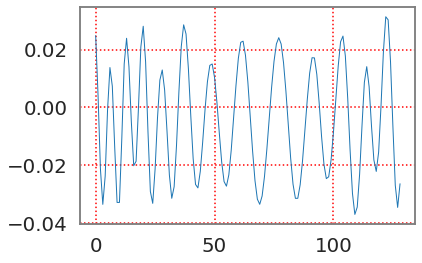

In [88]:
# plt.plot(x[0::n_macroparticles], lw=1)
plt.plot(rec_inc_x[:,0], lw=1);
# plt.xlim(10000, 10100)

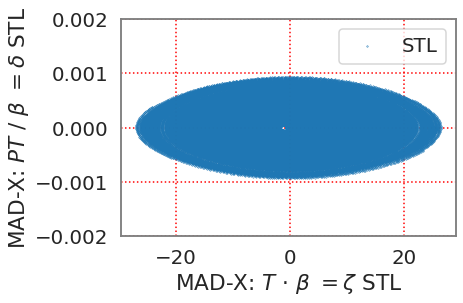

In [89]:
# plt.scatter(zeta, 
#             delta,
#             marker='.', s=1, label='STL')
plt.scatter(rec_inc_z, 
            rec_inc_dp,
            marker='.', s=1, label='STL')
plt.legend()
plt.ylim(-2e-3, 2e-3);
plt.xlabel(r'MAD-X: $T$ $\cdot$ $\beta$ $=\zeta$ STL')
plt.ylabel(r'MAD-X: $PT$ $/$ $\beta$ $=\delta$ STL');
# plt.title('MAD-X vs. SixTrackLib\nLongitudinal Phase Space');

# Tune shifts

In [90]:
print ('Space charge induced (Gaussian!) tune spread:')

D_x_avg = sum(np.array(sc_twdata['dispersion_x']) * np.array(sc_lengths)) / twiss.summary.length
D_y_avg = sum(np.array(sc_twdata['dispersion_y']) * np.array(sc_lengths)) / twiss.summary.length

lmbda = intensity * charge / (np.sqrt(2*np.pi) * sig_z_orig)
Ksc = charge / (gamma**3 * mass * (beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = twiss.summary.length / (2*np.pi)

sig_x = np.sqrt(epsx_rms_fin #epsn_x / (beta * gamma) 
                * R / qx + D_x_avg**2 * sig_dp_orig**2)
sig_y = np.sqrt(epsy_rms_fin #epsn_y / (beta * gamma) 
                * R / qy + D_y_avg**2 * sig_dp_orig**2)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    'incoherent KV tune shift'
    return Ksc * R**2 / (4 * thistune * thissize * (thissize+theothersize))

dQ_sc_x = 2 * dQ_inc(sig_x, sig_y, qx)
dQ_sc_y = 2 * dQ_inc(sig_y, sig_x, qy)

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_sc_x, dQ_sc_y))

Space charge induced (Gaussian!) tune spread:
dQ_x = 0.198 and dQ_y = 0.303


In [91]:
print ('Chromaticity induced RMS tune shift:')

dQ_chroma_x = twiss.summary.dq1 * beta * sig_dp
dQ_chroma_y = twiss.summary.dq2 * beta * sig_dp

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_chroma_x, dQ_chroma_y))

Chromaticity induced RMS tune shift:
dQ_x = -0.010 and dQ_y = -0.011


In [92]:
print ('SC + Chroma tune shift:')

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    np.abs(dQ_sc_x) + np.abs(dQ_chroma_x), 
    np.abs(dQ_sc_y) + np.abs(dQ_chroma_y)))

SC + Chroma tune shift:
dQ_x = 0.209 and dQ_y = 0.314


In [101]:
def get_tune(signal, turns=n_turns):
    try:
        return pnf.naff(signal - np.mean(signal), turns, 1, 0 , False, window=1)[0, 1]
    except IndexError:
        return np.nan

In [102]:
qx_i = np.apply_along_axis(get_tune, 1, rec_inc_x.T)
qy_i = np.apply_along_axis(get_tune, 1, rec_inc_y.T)

In [95]:
# qx_i = np.apply_along_axis(get_tune, 1, x.reshape((nturns, npart)).T)
# qy_i = np.apply_along_axis(get_tune, 1, y.reshape((nturns, npart)).T)

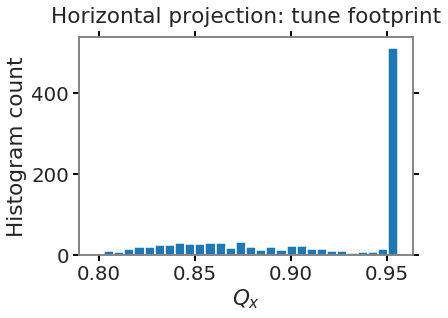

In [103]:
n, bins, _ = plt.hist(1 - qx_i, bins=30, label='128 first turns')
plt.xlabel("$Q_x$")
plt.ylabel('Histogram count')
plt.title('Horizontal projection: tune footprint', y=1.04)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('horizontalspectrum.png', dpi=150, bbox_inches='tight')

In [104]:
print ('max. dQ_x from tune footprint: {:.3f}'.format(bins[-1] - bins[0]))

max. dQ_x from tune footprint: 0.159


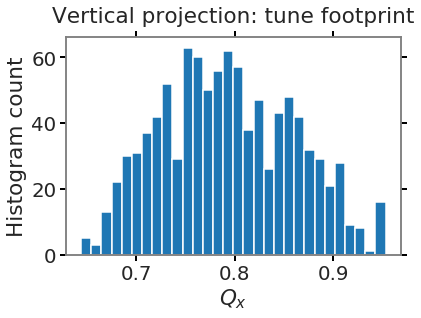

In [105]:
n, bins, _ = plt.hist(1 - qy_i, bins=30, label='128 first turns')
plt.xlabel("$Q_x$")
plt.ylabel('Histogram count')
plt.title('Vertical projection: tune footprint', y=1.04)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('verticalspectrum.png', dpi=150, bbox_inches='tight')

In [106]:
print ('max. dQ_y from tune footprint: {:.3f}'.format(bins[-1] - bins[0]))

max. dQ_y from tune footprint: 0.308


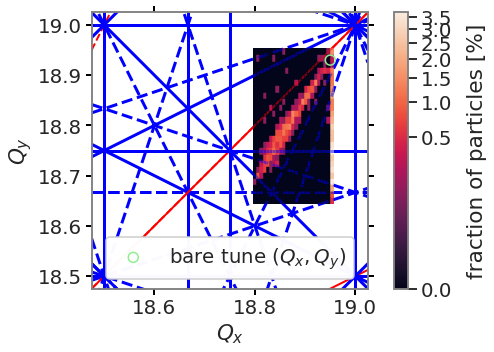

In [100]:
fig = plt.figure(figsize=(8,5)) 

extent_x = (np.floor(Qx) + 0.475, np.ceil(Qx) + 0.025)
extent_y = (np.floor(Qy) + 0.475, np.ceil(Qy) + 0.025)

resonances = ResonanceLines(extent_x, 
                            extent_y,
                            range(1, 4+1), 6) #1
resonances.plot_resonance(fig)
plt.gca().set_aspect('equal')

inc_tunes_x = np.floor(Qx) + 1 - np.abs(qx_i)[~np.isnan(qx_i)&~np.isnan(qy_i)]
inc_tunes_y = np.floor(Qy) + 1 - np.abs(qy_i)[~np.isnan(qy_i)&~np.isnan(qx_i)]

plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25,
           zorder=3, alpha=0.5, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
cbar = plt.colorbar()
cbar.set_label('fraction of particles [%]', labelpad=15)

plt.xlim(extent_x)
plt.ylim(extent_y)

plt.scatter(Qx, Qy, color='lightgreen', marker='o', facecolor='None', 
            linestyle='None', s=100, zorder=13, label=r"bare tune $(Q_x,Q_y)$")
plt.legend(loc=8, framealpha=0.98)

plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)

plt.tight_layout()
plt.savefig('tunespread.png', dpi=150, bbox_inches='tight')